In [1]:
import copy
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wandb
import wandb.apis

api = wandb.Api()

In [12]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary:
        task = run.config["task"]["name"]
        mc = run.summary["model_config"]
        score_key = dict(
            squad="match", triviaqa="match", cnn_dailymail="rougeL", wikitext_bpc="bpc", repetition="match_length"
        )[task]
        scores = [r[score_key] for r in run.summary["results"]]
        sparsity = copy.deepcopy(run.config["sparsity"])
        sparsity_score = sparsity.pop("score", None)
        if sparsity_score is not None and sparsity_score.pop("name", None) == "sparse_q":
            return dict(
                task=task,
                model=run.config["model"].split("/")[1].replace("-hf", "").lower(),
                n_heads=mc["num_attention_heads"] * mc["num_hidden_layers"],
                head_size=mc["hidden_size"]//mc["num_attention_heads"],
                **sparsity,
                **sparsity_score,
                # prefill_length=run.summary["prefill_length"],
                score=np.mean(scores),
                score_stderr=np.sqrt(np.var(scores) / len(scores)),
            )

def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))

def memory_transfers_attention_only(s: pd.Series, count_kv: bool = True, count_index: bool = True) -> int:
    kv_elements, index_elements = 0, 0  # per-head
    if s["name"] == "dense":
        # write 1*(k, v) + read all prefill_length*(k, v)
        kv_elements = (2 + 2 * s["prefill_length"]) * s["head_size"]

    elif s["name"] == "sparse_v":
        # write 1*(k, v) + read all prefill_length*k + read sparse_k*v
        kv_elements = (2 + s["prefill_length"] + s["k"]) * s["head_size"]

    elif s["name"] == "eviction":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write scores
        index_elements = (1 + 2 * s["prefill_length"])

    elif s["name"] == "ann":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write index
        index_elements = s["head_size"] + s["prefill_length"] * s["rank"]
        if s["reallocate_to_mean_value"]:
            index_elements += 2 * s["head_size"]

    else:
        assert False, s["name"]

    return (count_kv * kv_elements + count_index * index_elements) * s["n_heads"]

df = (
    load_sweep("RMOE-62-repetition-task-test")
    # .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    [["task", "model", "name", "k", "rank", "score", "score_stderr"]]
)
df.head()

,task,model,name,k,rank,score,score_stderr
0,repetition,pythia-2.8b,ann,32,64,152.746,4.616379
1,repetition,pythia-2.8b,ann,32,16,124.222,4.437278
2,repetition,pythia-2.8b,ann,32,8,65.934,2.920887
3,repetition,pythia-1.4b,ann,32,64,67.312,2.928610
4,repetition,pythia-1.4b,ann,32,16,33.810,1.601518


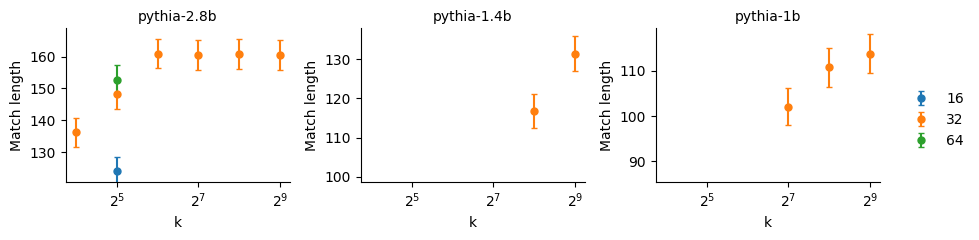

In [19]:
models = ["pythia-2.8b", "pythia-1.4b", "pythia-1b"]

fig, axs = plt.subplots(1, len(models), figsize=(3*len(models), 2.5))
for model, ax in zip(models, axs):
    sns.despine(ax=ax)
    ax.set_title(model, fontsize=10, pad=5)
    d = df[(df.model==model)]
    if len(d):
        for rank in [16, 32, 64]:
            g = d[d["rank"] == rank]
            ax.errorbar(x=g.k, y=g.score, yerr=g.score_stderr, fmt="o", ms=5, capsize=2, label=str(rank))
        ax.set_xscale("log", base=2)
        max_score = d["score"].max()
        ax.set_ylim((max_score*.75, max_score*1.05))
        ax.set_xlabel("k")
        ax.set_ylabel("Match length")

fig.legend(*axs[0].get_legend_handles_labels(), loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
plt.tight_layout()